In [3]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2

all_experiments = []

for pool_size in [64, 1024, 16384]:

    all_experiments.append("official_1_UQ_poolSize_" + str(pool_size))

## load everything

model_dic = {}
config_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}
OLS_mus_dic = {}
OLS_sigs_dic = {}


for experiment in all_experiments:

    model_path = os.path.join(root_path, experiment)

    model, _ = get_model_from_run(model_path)

    config = config_load_special(model_path)

    model_dic[experiment] = model

    config_dic[experiment] = config

# generate test data
sample_key = list(config_dic.keys())[0]

n_dims = config_dic[sample_key].model.n_dims
batch_size = 20*config_dic[sample_key].training.batch_size

data_sampler = get_data_sampler(config_dic[sample_key].training.data, n_dims)
xs = data_sampler.sample_xs(b_size=batch_size, n_points=config_dic[sample_key].training.curriculum.points.end)


groups = {
            # "low_sig": (80, 20),
            "original": (20, 20),
            # "large_sig": (100, 400),
            # "huge_sig": (100, 1600)
        }

for experiment in all_experiments:

    for sig_config in list(groups.keys()):


        ## reset w and sigma of task samplers

        mu0 = np.ones(n_dims)

        ## gamma(a, b), mean = a/b, variance = a/b^2
        ## when training, we let a/b=1 and b relatively large

        a0, b0 = groups[sig_config]

        new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

        new_exp = experiment + "_" + sig_config

        config_dic[new_exp] = copy.deepcopy(config_dic[experiment])

        config_dic[new_exp].training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
        config_dic[new_exp].training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
        config_dic[new_exp].training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

        task_sampler = get_task_sampler(
            config_dic[new_exp].training.task,
            n_dims,
            batch_size,
            **config_dic[new_exp].training.task_kwargs
        )

        task = task_sampler()

        mus, ys, sigma, exemps = task.eval_with_mu_sigma_exempt(xs)

        ys_dic[new_exp] = ys
        mus_dic[new_exp] = mus
        exempt_dic[new_exp]= exemps
        sigs_dic[new_exp] = sigma


        with torch.no_grad():
            pred = model_dic[experiment](xs, ys)

        predmu_dic[new_exp] = pred[:, :, 0]
        predsigma_dic[new_exp] = pred[:, :, 1]

        posterior_mu = np.zeros(predmu_dic[new_exp].shape)
        posterior_sigma = np.zeros(predmu_dic[new_exp].shape)
        ridge_mu = np.zeros(predmu_dic[new_exp].shape)
        ridge_sigma = np.zeros(predmu_dic[new_exp].shape)
        OLS_mu = np.zeros(predmu_dic[new_exp].shape)
        OLS_sigma = np.zeros(predmu_dic[new_exp].shape)


        for selected_index in range(len(predmu_dic[new_exp])):

            # estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
            #                                                 , mu0, MAP_sig=False, bias_adjust=True, pred_Ys= pred[selected_index, :, 0].cpu().numpy())

            estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
                                                            , mu0, MAP_sig=False, bias_adjust=False)


            real_estimated_ws = np.zeros(estimated_ws.shape)
            real_estimated_sigs = np.zeros(estimated_sigs.shape)

            real_estimated_ws[0] = mu0
            # real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2)
            real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2))




            # print("adjust_amount: ", np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2) \
            #       - np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2)))

            real_estimated_ws[1:] = estimated_ws[:-1]
            real_estimated_sigs[1:] = estimated_sigs[:-1]

            posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
            posterior_sigma[selected_index, :] = real_estimated_sigs


            ridge_ws, ridge_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index], alpha=0.5)
            
            ridge_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(ridge_ws[:-1], axis=-1))[:, 0, 0]
            ridge_sigma[selected_index, 1:] = ridge_sigs[:-1]


            OLS_ws, OLS_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index], alpha=0.001)
            
            OLS_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(OLS_ws[:-1], axis=-1))[:, 0, 0]
            OLS_sigma[selected_index, 1:] = OLS_sigs[:-1]



        bayes_mus_dic[new_exp] = posterior_mu
        bayes_sigs_dic[new_exp] = posterior_sigma
        ridge_mus_dic[new_exp] = ridge_mu
        ridge_sigs_dic[new_exp] = ridge_sigma
        OLS_mus_dic[new_exp] = OLS_mu
        OLS_sigs_dic[new_exp] = OLS_sigma


# 30min

## Plot the average squared Loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


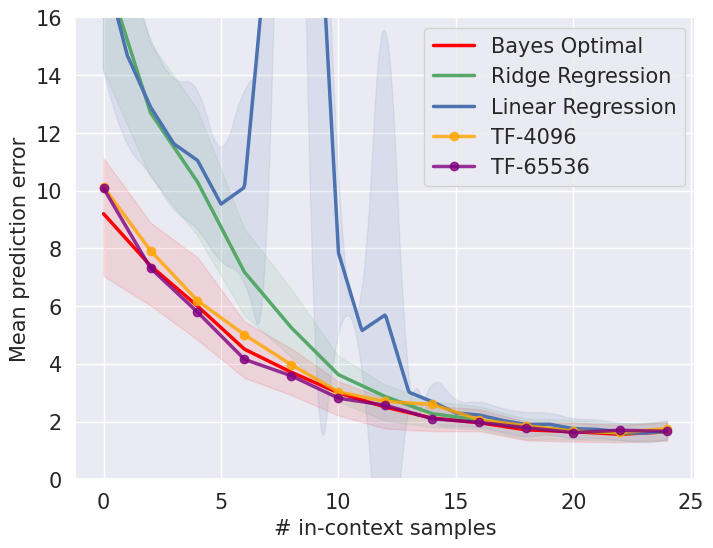

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline



def softplus(arr):
    return np.log(1+np.exp(arr))


L2_Bayes = {}
L2_Ridge = {}
L2_OLS = {}

L2_Bayes_fluc = {}
L2_Ridge_fluc = {}
L2_OLS_fluc = {}

L2_model = {}




for sig_config in list(groups.keys()):
    
    sample_experiment = "official_1_UQ_poolSize_16384_" + sig_config

    real_ys = ys_dic[sample_experiment].numpy()
    bayes_mus = bayes_mus_dic[sample_experiment]
    ridge_mus = ridge_mus_dic[sample_experiment]
    OLS_mus = OLS_mus_dic[sample_experiment]

    L2_Bayes[sig_config] = np.square(real_ys - bayes_mus).mean(axis=0)
    L2_Bayes_fluc[sig_config] = np.square(real_ys - bayes_mus).std(axis=0)
    L2_Ridge[sig_config] = np.square(real_ys - ridge_mus).mean(axis=0)
    L2_Ridge_fluc[sig_config] = np.square(real_ys - ridge_mus).std(axis=0)
    L2_OLS[sig_config] = np.square(real_ys - OLS_mus).mean(axis=0)
    L2_OLS_fluc[sig_config] = np.square(real_ys - OLS_mus).std(axis=0)


for sig_config in list(groups.keys()):
    for pool_size in [64, 1024, 16384]:

        experiment = "official_1_UQ_poolSize_" + str(pool_size) + "_" + sig_config        

        real_ys = ys_dic[experiment][:500].numpy()
        preds = predmu_dic[experiment][:500].numpy()

        L2_model[sig_config + "_" + str(pool_size)] = np.square(real_ys - preds).mean(axis=0)




# Sample data
x_range = 25
x_base = np.arange(0, x_range)
dist_setting = "original"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base[::2], savgol_filter(L2_Bayes[dist_setting][:x_range], \
                                   window_length=5, polyorder=2)[::2], '-', label='Bayes Optimal', color="red", linewidth=2.5)
ax.fill_between(x_base[::2], L2_Bayes[dist_setting][:x_range][::2] - L2_Bayes_fluc[dist_setting][:x_range][::2]/8, \
                L2_Bayes[dist_setting][:x_range][::2] + L2_Bayes_fluc[dist_setting][:x_range][::2]/8, \
                    color='red', alpha=0.1)


ax.plot(x_base[::2], savgol_filter(L2_Ridge[dist_setting][:x_range], window_length=5, polyorder=2)[::2], \
        '-', label='Ridge Regression', color="g", linewidth=2.5, alpha=1)
ax.fill_between(x_base[::2], L2_Ridge[dist_setting][:x_range][::2] - L2_Ridge_fluc[dist_setting][:x_range][::2]/8, \
                L2_Ridge[dist_setting][:x_range][::2] + L2_Ridge_fluc[dist_setting][:x_range][::2]/8, \
                    color='g', alpha=0.1)


x_axis_vals = x_base
y_axis_vals = L2_OLS[dist_setting][:x_range]
X_Y_Spline = make_interp_spline(x_axis_vals, y_axis_vals, k=1)
X_ = np.linspace(x_axis_vals.min(), x_axis_vals.max(), 500)
Y_ = X_Y_Spline(X_)
ax.plot(X_, Y_, \
        '-', label='Linear Regression', color="b", linewidth=2.5, alpha=1)

lower_part = L2_OLS[dist_setting][:x_range] - L2_OLS_fluc[dist_setting][:x_range]/8
lower_X_Y_Spline = make_interp_spline(x_axis_vals, lower_part, k=2)
lower_ = lower_X_Y_Spline(X_)

upper_part = L2_OLS[dist_setting][:x_range] + L2_OLS_fluc[dist_setting][:x_range]/8
upper_X_Y_Spline = make_interp_spline(x_axis_vals, upper_part, k=2)
upper_ = upper_X_Y_Spline(X_)
ax.fill_between(X_, lower_, upper_, color='b', alpha=0.1)



ax.plot(x_base[::2], savgol_filter(L2_model[dist_setting + "_1024"][:x_range], window_length=1, polyorder=0)[::2], \
        'o-', label='TF-4096', color="orange", linewidth=2.5, alpha=0.8)

ax.plot(x_base[::2], savgol_filter(L2_model[dist_setting + "_16384"][:x_range], window_length=1, polyorder=0)[::2], \
        'o-', label='TF-65536', color="purple", linewidth=2.5, alpha=0.8)


# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Mean prediction error', fontsize="15")
ax.set_ylim(0, 16) 
# ax.set_title('Square Error by Algorithm', fontsize="15", fontweight='bold')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

plt.savefig('figures/exp_1_L2_compare.eps', format='eps')
plt.savefig('figures/exp_1_L2_compare.png', format='png')

# Show plot
plt.show()


## Plot the estimated sigma

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


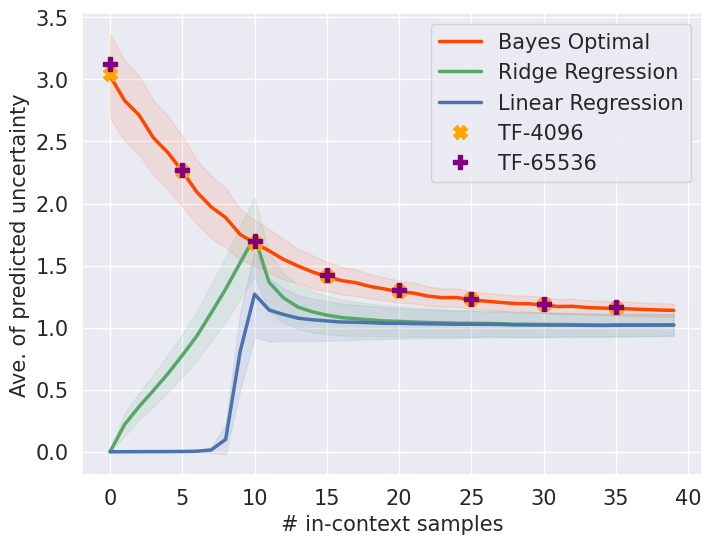

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


std_Bayes = {}
std_Ridge = {}
std_OLS = {}
std_model = {}
std_Bayes_fluc = {}
std_Ridge_fluc = {}
std_OLS_fluc = {}
std_model_fluc = {}




for sig_config in list(groups.keys()):
    
    sample_experiment = "official_1_UQ_poolSize_16384_" + sig_config

    bayes_mus = bayes_mus_dic[sample_experiment]
    ridge_mus = ridge_mus_dic[sample_experiment]
    OLS_mus = OLS_mus_dic[sample_experiment]

    std_Bayes[sig_config] = bayes_sigs_dic[sample_experiment].mean(axis=0)
    std_Ridge[sig_config] = ridge_sigs_dic[sample_experiment].mean(axis=0)
    std_OLS[sig_config] = OLS_sigs_dic[sample_experiment].mean(axis=0)

    std_Bayes_fluc[sig_config] = bayes_sigs_dic[sample_experiment].std(axis=0)
    std_Ridge_fluc[sig_config] = ridge_sigs_dic[sample_experiment].std(axis=0)
    std_OLS_fluc[sig_config] = OLS_sigs_dic[sample_experiment].std(axis=0)


for sig_config in list(groups.keys()):
    for pool_size in [64, 1024, 16384]:

        experiment = "official_1_UQ_poolSize_" + str(pool_size) + "_" + sig_config        

        std_model[sig_config + "_" + str(pool_size)] = softplus(predsigma_dic[experiment].numpy()).mean(axis=0)
        std_model_fluc[sig_config + "_" + str(pool_size)] = softplus(predsigma_dic[experiment].numpy()).std(axis=0)




# Sample data
x_range = 40
x_base = np.arange(0, x_range)
dist_setting = "original"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base, savgol_filter(std_Bayes[dist_setting][:x_range], window_length=1, polyorder=0),\
         '-', label='Bayes Optimal', color="orangered", linewidth = 2.5)
ax.fill_between(x_base, std_Bayes[dist_setting][:x_range] - std_Bayes_fluc[dist_setting][:x_range]/2, \
                std_Bayes[dist_setting][:x_range] + std_Bayes_fluc[dist_setting][:x_range]/2, \
                    color='orangered', alpha=0.1)


ax.plot(x_base, savgol_filter(std_Ridge[dist_setting][:x_range], window_length=1, polyorder=0), \
        '-', label='Ridge Regression', color="g", linewidth=2.5)
ax.fill_between(x_base, std_Ridge[dist_setting][:x_range] - std_Ridge_fluc[dist_setting][:x_range]/2, \
                std_Ridge[dist_setting][:x_range] + std_Ridge_fluc[dist_setting][:x_range]/2, \
                    color='g', alpha=0.1)


ax.plot(x_base, savgol_filter(std_OLS[dist_setting][:x_range], window_length=1, polyorder=0), \
        '-', label='Linear Regression', color="b", linewidth=2.5)
ax.fill_between(x_base, std_OLS[dist_setting][:x_range] - std_OLS_fluc[dist_setting][:x_range]/2, \
                std_OLS[dist_setting][:x_range] + std_OLS_fluc[dist_setting][:x_range]/2, \
                    color='b', alpha=0.1)

ax.plot(x_base[::5], savgol_filter(std_model[dist_setting + "_1024"][:x_range][::5], window_length=1, polyorder=0), \
        'X', label='TF-4096', color="orange", ms=10)

ax.plot(x_base[::5], savgol_filter(std_model[dist_setting + "_16384"][:x_range][::5], window_length=1, polyorder=0), \
        'P', label='TF-65536', color="purple", ms=10)

# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('Ave. of predicted uncertainty', fontsize="15")
# ax.set_ylim(0, 1) 
# ax.set_title('Uncertainty Prediction by Algorithm', fontsize="15", fontweight='bold')

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.savefig('figures/exp_1_Std_pred.eps', format='eps')
plt.savefig('figures/exp_1_Std_pred.png', format='png')

# Show plot
plt.show()


## prediction quality of uncertainty

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


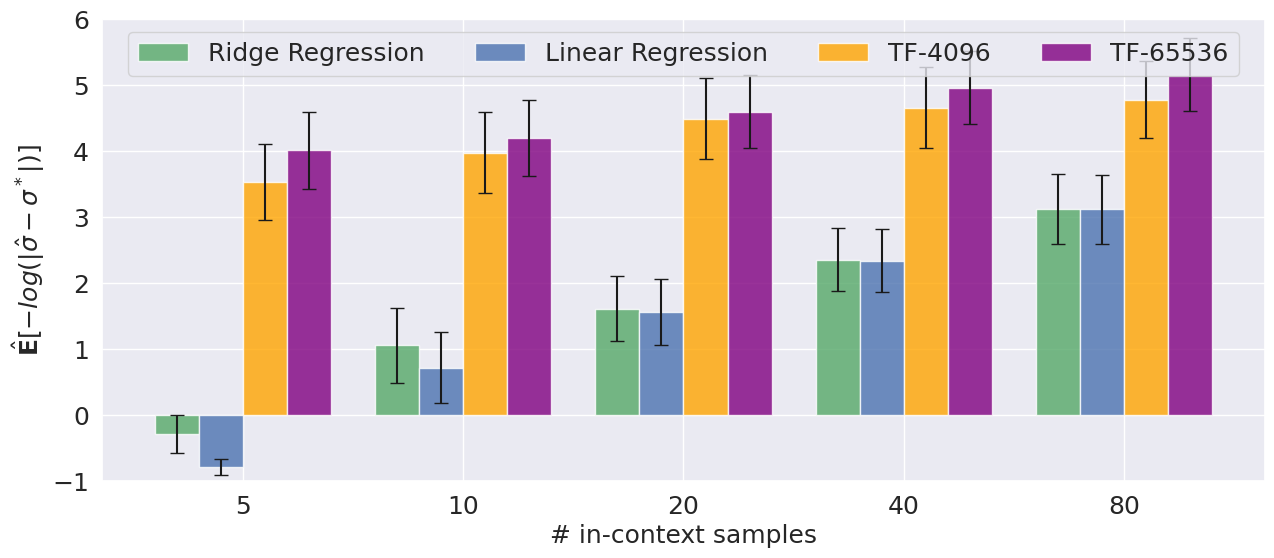

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data

target_steps = [5, 10, 20, 40, 80]

categories = []

for step in target_steps:
    categories.append(str(step))

noise_std = np.arange(len(categories))

# Means and standard deviations for each algorithm at each noise level
sig_config = "original"
experiment = "official_1_UQ_poolSize_16384_" + sig_config 

OLS_dev = -np.log(np.abs(OLS_sigs_dic[experiment] - bayes_sigs_dic[experiment]))
Ridge_dev = -np.log(np.abs(ridge_sigs_dic[experiment] - bayes_sigs_dic[experiment]))


TF_dev = -np.log(np.abs(softplus(predsigma_dic[experiment].numpy()) - bayes_sigs_dic[experiment]))

low_pool_exp = "official_1_UQ_poolSize_1024_" + sig_config 
TF_low_dev = -np.log(np.abs(softplus(predsigma_dic[low_pool_exp].numpy()) - bayes_sigs_dic[low_pool_exp]))


OLS_means = [OLS_dev.mean(axis=0)[step] for step in target_steps]
OLS_std = [OLS_dev.std(axis=0)[step]/2 for step in target_steps]


Ridge_means = [Ridge_dev.mean(axis=0)[step] for step in target_steps]
Ridge_std = [Ridge_dev.std(axis=0)[step]/2 for step in target_steps]


TF_means = [TF_dev.mean(axis=0)[step] for step in target_steps]
TF_std = [TF_dev.std(axis=0)[step]/2 for step in target_steps]

TF_low_means = [TF_low_dev.mean(axis=0)[step] for step in target_steps]
TF_low_std = [TF_low_dev.std(axis=0)[step]/2 for step in target_steps]




# Bar width
width = 0.2

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot bars
rects1 = ax.bar(noise_std - 1.5*width, Ridge_means, width, label='Ridge Regression', yerr=Ridge_std, capsize=5, color='g',alpha=0.8)
rects2 = ax.bar(noise_std - 0.5*width, OLS_means, width, label='Linear Regression', yerr=OLS_std, capsize=5, color='b',alpha=0.8)
rects3 = ax.bar(noise_std + 0.5*width, TF_low_means, width, label='TF-4096', yerr=TF_low_std, capsize=5, color='orange',alpha=0.8)
rects4 = ax.bar(noise_std + 1.5*width, TF_means, width, label='TF-65536', yerr=TF_std, capsize=5, color='purple',alpha=0.8)



# Labels and title
ax.set_xlabel('# in-context samples', fontsize="18")
ax.set_ylabel('$\hat{\mathbf{E}}[-log(|\hat{\sigma}-\sigma^*|)]$', fontsize="18", rotation=90, fontweight='bold')
# ax.set_title('Prediction Quality of Uncertainty', fontsize="15", fontweight='bold')
ax.set_xticks(noise_std)
ax.set_xticklabels(categories)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="18", loc="upper center", ncol=4)
ax.set_ylim(-1, 6) 
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

plt.savefig('figures/exp_1_Uncertainty_Quality.eps', format='eps')
plt.savefig('figures/exp_1_Uncertainty_Quality.png', format='png')

# Show plot
plt.show()
